In [37]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras import Model
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow

**Data preparation**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def convert_predicted(pred):
    converted_pred = []
    for row in pred:
        if np.argmax(row) == 0:
            converted_pred.append([1, 0])
        elif np.argmax(row) == 1:
            converted_pred.append([0, 1])
    return converted_pred

In [9]:
types_num = 2
fire_images_path = '/content/drive/MyDrive/nn_project/fire_images'
non_fire_images_path = '/content/drive/MyDrive/nn_project/non_fire_images'

fire_data = []
files = os.listdir(fire_images_path)
for filename in files:
    path = os.path.join(fire_images_path, filename)
    img = cv2.imread(path)
    if img is not None:
        img = cv2.resize(img, (128, 128))
        fire_data.append(img)

non_fire_data = []
files = os.listdir(non_fire_images_path)
for filename in files:
    path = os.path.join(non_fire_images_path, filename)
    img = cv2.imread(path)
    if img is not None:
        img = cv2.resize(img, (128, 128))
        non_fire_data.append(img)

fire_labels = [1 for _ in range(len(fire_data))]
non_fire_labels = [0 for _ in range(len(non_fire_data))]

data = np.array(fire_data + non_fire_data)
labels = np.array(fire_labels + non_fire_labels)

idxes = np.random.permutation(len(data))
data = data[idxes]
labels = labels[idxes]

size = int(len(data) * 0.8)
X_train, X_test = data[:size], data[size:]
y_train, y_test = labels[:size], labels[size:]

X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, types_num)
y_test = tf.keras.utils.to_categorical(y_test, types_num)


**Model**

In [27]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(types_num, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

**Train**

In [28]:
n_epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=n_epochs, validation_data=(X_test, y_test))

Epoch 1/25
45/45 [==============================] - 13s 165ms/step - loss: 0.7202 - accuracy: 0.6709 - val_loss: 0.7610 - val_accuracy: 0.4605
Epoch 2/25
45/45 [==============================] - 6s 132ms/step - loss: 0.3332 - accuracy: 0.8507 - val_loss: 0.7597 - val_accuracy: 0.4605
Epoch 3/25
45/45 [==============================] - 6s 127ms/step - loss: 0.2350 - accuracy: 0.9066 - val_loss: 0.7194 - val_accuracy: 0.4548
Epoch 4/25
45/45 [==============================] - 6s 128ms/step - loss: 0.1333 - accuracy: 0.9561 - val_loss: 0.6978 - val_accuracy: 0.4520
Epoch 5/25
45/45 [==============================] - 6s 132ms/step - loss: 0.1072 - accuracy: 0.9625 - val_loss: 0.8798 - val_accuracy: 0.4605
Epoch 6/25
45/45 [==============================] - 6s 133ms/step - loss: 0.0826 - accuracy: 0.9731 - val_loss: 1.1380 - val_accuracy: 0.4605
Epoch 7/25
45/45 [==============================] - 6s 131ms/step - loss: 0.0521 - accuracy: 0.9851 - val_loss: 1.1755 - val_accuracy: 0.4520
Epoch

**Accuracy metrics**

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

12/12 [==============================] - 0s 38ms/step - loss: 0.1218 - accuracy: 0.9605
Test Loss: 0.1218
Test Accuracy: 0.9605


12/12 [==============================] - 1s 37ms/step


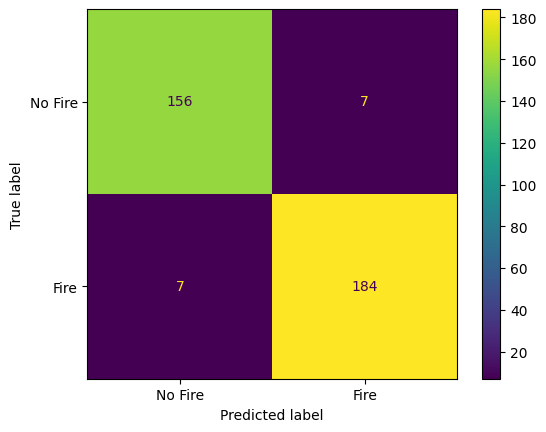

In [30]:
predictions = model.predict(X_test)

cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire', 'Fire'])
disp.plot()
plt.show()

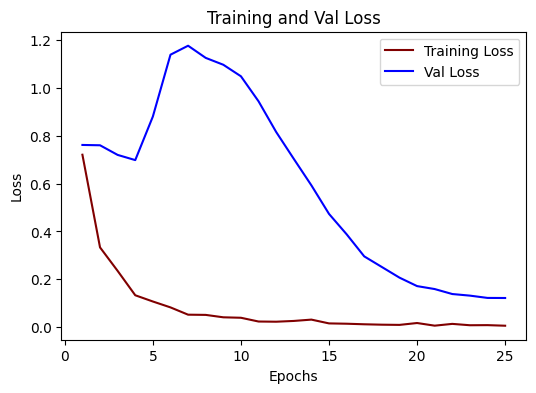

In [32]:
epochs_range = list(range(1, n_epochs + 1))
plt.figure(figsize=(6, 4))

plt.plot(epochs_range, history.history['loss'], label='Training Loss', color='maroon')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Val Loss')
plt.show()

**Random images prediction**

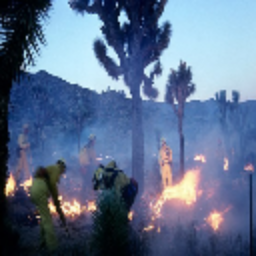

1/1 [==============================] - 0s 26ms/step
Fire



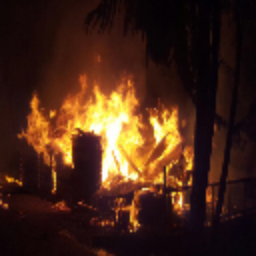

1/1 [==============================] - 0s 23ms/step
Fire



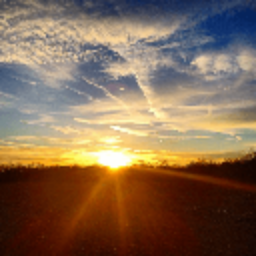

1/1 [==============================] - 0s 24ms/step
No Fire



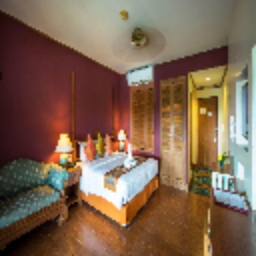

1/1 [==============================] - 0s 23ms/step
No Fire



In [44]:
random_images = random.choices(X_test, k=4)

for img in random_images:
    resized_img = cv2.resize(img, (256, 256))
    resized_img *= 255
    cv2_imshow(resized_img)

    prediction = model.predict(np.array([img]))

    if np.argmax(prediction):
        print('Fire')
    else:
        print('No Fire')
    print()

**Save model**

In [45]:
model.save('/content/drive/MyDrive/fire_classification_model.h5')